In [3]:
import time
import os
import os.path as osp
import sys
import io
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *

import matplotlib
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device Used: " + str(device))

# set random seed
manual_seed = 17 #42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Device Used: cpu


In [4]:
## Data and Experiment Config

# Set Result Directory
# this folder's name should describe the configuration
result_folder = './GLO'
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

# Load Data
data_folder = "./Data/Dataset_5_35"
training_data_complete = np.load(osp.join(data_folder, "spectra_complete_training.npy")).astype(np.float32) #"log_training.npy"
NLA_max = 205 
training_data = training_data_complete[:,:NLA_max] #manually delete very high wavelengths
TRAINING_DATA = training_data.shape[0]
FEATURE_SIZE = training_data.shape[1]
print("#Signal ", TRAINING_DATA)
print("#Measurements ", FEATURE_SIZE)


# Hyperparameters (could receive as arguments along with data/res directory)
LATENT_SIZE = 50

BATCH_SIZE = 100 #32,64,128
NUM_EPOCHS = 10000

LOG_EVERY = 10   #error logging
SAVE_EVERY = 100  #checkpoints and model saving

LR_MODEL = 0.5
LR_LATENT = 0.05

#Signal  9000
#Measurements  205


In [5]:
## Model Definition

# ~~toy code without dataloaders

# Initialize model
d = 6 #num layers
netG = Generator(nz=LATENT_SIZE, nf=FEATURE_SIZE, num_hidden_layers=d).to(device)
model_size = sum(p.numel() for p in netG.parameters())
print("Generative Model size (total): {:.3f}M".format(model_size/1e6))


## Training Config


# GLO training requires projection of latent code in the l2 unit ball 
def project_l2_ball(z):
    """ project the vectors in z onto the l2 unit norm ball"""
    z_l2_norm = torch.norm(z, p=2, dim=0).detach()
    if z_l2_norm.item() > 1:
        z = z.div(z_l2_norm.expand_as(z))
    return z

# placeholder variable for learnable latent code
Zin = torch.ones(BATCH_SIZE, LATENT_SIZE, device=device, requires_grad=True)
latent_codes = torch.randn(TRAINING_DATA, LATENT_SIZE, device=device)
# project onto unit ball (see GLO paper)
for idx in range(TRAINING_DATA):
    latent_codes[idx] = project_l2_ball(latent_codes[idx])

# Setup Adam optimizers for both model parameters and latent codes 
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
optimizer = optim.Adam([
        {'params': netG.parameters(), 'lr': LR_MODEL, 'weight_decay': 0.001}, 
        {'params': Zin, 'lr': LR_LATENT, 'weight_decay': 0.001}
    ])

# Learning rate decay
decayRate = 0.5
step = 2000 #decay every 2000 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step, gamma=decayRate)

# Training Loss
criterion = nn.MSELoss(reduction='sum')

# Print info
print("Model Architecture:")
print(netG)

Generative Model size (total): 0.251M
Model Architecture:
Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=101, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(101, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=101, out_features=153, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(153, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Linear(in_features=153, out_features=204, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Se

In [6]:
## Training

# Preliminaries : 
# 1) training requires restriction of latent codes in the l2 unit ball 
def project_l2_ball(z):
    """ project the vectors in z onto the l2 unit norm ball"""
    z_l2_norm = torch.norm(z, p=2, dim=0).detach()
    if z_l2_norm.item() > 1:
        z = z.div(z_l2_norm.expand_as(z))
    return z


# Training Loop

# Lists to keep track of progress
losses = []

print("Starting Training Loop...")
netG.train()
# For each epoch
for epoch in range(NUM_EPOCHS):
    # Manually build batches for current epoch. For SDSS data toy code without dataloaders.
    ids = np.asarray(np.random.permutation(np.arange(TRAINING_DATA)))
    num_batches = TRAINING_DATA//BATCH_SIZE
    batches = np.split(ids, num_batches)
    # initialize loss accumulator 
    err = 0.0
    # For each batch
    for i, ids in enumerate(batches):   
        netG.zero_grad()
        # Format batch
        data = torch.tensor(training_data[ids], device=device)
        b_size = data.size(0)
        # get latent codes
        z = latent_codes[ids]
        # load latent codes in variable
        Zin.data = z
        # get instance reconstruction
        output = netG(Zin)
        # calculate loss
        loss = criterion(output,data)
        # run optimization step
        optimizer.zero_grad()  # zero the gradient buffer
        loss.backward()
        optimizer.step()
        
        # get the updated latent codes
        new_latent_codes = Zin.data
        #restrict into ball
        for idx in range(BATCH_SIZE):
            new_latent_codes[idx] = project_l2_ball(new_latent_codes[idx])
        latent_codes[ids] = new_latent_codes
        
        err += loss.item()
    
    # Learning rate decay
    lr_scheduler.step()

    # Reduce error by taking the average
    err = err/TRAINING_DATA
        
    # Save Losses for plotting later
    losses.append(err)
        
    # Output training stats
    if ((epoch+1) % LOG_EVERY == 0):
        print('Epoch[%d/%d]\tLoss: %.4f' % (epoch+1, NUM_EPOCHS, err))

    # Checkpoint generator
    if ((epoch+1) % SAVE_EVERY == 0):
        # save learned model so far
        torch.save(netG.state_dict(), osp.join(result_folder,"learned_generator_%d.pth")%(epoch+1))
        
# save the learned model and stats at the end of training 
torch.save(netG.state_dict(), osp.join(result_folder,"learned_model.pth"))
torch.save(latent_codes, osp.join(result_folder,"learned_latent_codes.pth"))
np.save(osp.join(result_folder,"losses.npy"), np.asarray(losses))

Starting Training Loop...
Epoch[10/10000]	Loss: 186.4178
Epoch[20/10000]	Loss: 157.9031
Epoch[30/10000]	Loss: 139.3065
Epoch[40/10000]	Loss: 112.7407
Epoch[50/10000]	Loss: 84.8251
Epoch[60/10000]	Loss: 73.1261
Epoch[70/10000]	Loss: 12223.1201
Epoch[80/10000]	Loss: 2255.2552
Epoch[90/10000]	Loss: 10442.8139
Epoch[100/10000]	Loss: 10191.6002
Epoch[110/10000]	Loss: 7546.9588
Epoch[120/10000]	Loss: 4273.3898
Epoch[130/10000]	Loss: 940.2715
Epoch[140/10000]	Loss: 874.0862
Epoch[150/10000]	Loss: 562.3922
Epoch[160/10000]	Loss: 441.7069
Epoch[170/10000]	Loss: 262.7743
Epoch[180/10000]	Loss: 198.0310
Epoch[190/10000]	Loss: 167.5853
Epoch[200/10000]	Loss: 146.5915
Epoch[210/10000]	Loss: 139.2939
Epoch[220/10000]	Loss: 134.3324
Epoch[230/10000]	Loss: 134.4739
Epoch[240/10000]	Loss: 133.4962
Epoch[250/10000]	Loss: 133.5405
Epoch[260/10000]	Loss: 189479.7567
Epoch[270/10000]	Loss: 45737.9461
Epoch[280/10000]	Loss: 953.5146
Epoch[290/10000]	Loss: 4240.4456
Epoch[300/10000]	Loss: 526.2731
Epoch[310/

Epoch[2520/10000]	Loss: 719.9635
Epoch[2530/10000]	Loss: 455.6121
Epoch[2540/10000]	Loss: 225.6718
Epoch[2550/10000]	Loss: 148.8730
Epoch[2560/10000]	Loss: 145.2531
Epoch[2570/10000]	Loss: 110.1026
Epoch[2580/10000]	Loss: 63.2374
Epoch[2590/10000]	Loss: 47.7376
Epoch[2600/10000]	Loss: 39.7690
Epoch[2610/10000]	Loss: 33.9175
Epoch[2620/10000]	Loss: 31.3003
Epoch[2630/10000]	Loss: 32.1264
Epoch[2640/10000]	Loss: 132.7770
Epoch[2650/10000]	Loss: 157.1434
Epoch[2660/10000]	Loss: 152.5767
Epoch[2670/10000]	Loss: 143.8677
Epoch[2680/10000]	Loss: 107.4555
Epoch[2690/10000]	Loss: 80.1748
Epoch[2700/10000]	Loss: 64.1018
Epoch[2710/10000]	Loss: 55.1439
Epoch[2720/10000]	Loss: 48.8420
Epoch[2730/10000]	Loss: 40.4841
Epoch[2740/10000]	Loss: 33.0498
Epoch[2750/10000]	Loss: 30.6752
Epoch[2760/10000]	Loss: 29.4433
Epoch[2770/10000]	Loss: 29.6500
Epoch[2780/10000]	Loss: 146.1640
Epoch[2790/10000]	Loss: 129.3090
Epoch[2800/10000]	Loss: 119.8361
Epoch[2810/10000]	Loss: 124.4700
Epoch[2820/10000]	Loss: 1

Epoch[5070/10000]	Loss: 16.6989
Epoch[5080/10000]	Loss: 12.9404
Epoch[5090/10000]	Loss: 11.8523
Epoch[5100/10000]	Loss: 10.9102
Epoch[5110/10000]	Loss: 11.3829
Epoch[5120/10000]	Loss: 10.4193
Epoch[5130/10000]	Loss: 12.2958
Epoch[5140/10000]	Loss: 69.0823
Epoch[5150/10000]	Loss: 31.6477
Epoch[5160/10000]	Loss: 22.7967
Epoch[5170/10000]	Loss: 19.1510
Epoch[5180/10000]	Loss: 16.6034
Epoch[5190/10000]	Loss: 15.2328
Epoch[5200/10000]	Loss: 14.1011
Epoch[5210/10000]	Loss: 12.7794
Epoch[5220/10000]	Loss: 11.4992
Epoch[5230/10000]	Loss: 12.1762
Epoch[5240/10000]	Loss: 11.6116
Epoch[5250/10000]	Loss: 64.0239
Epoch[5260/10000]	Loss: 35.5006
Epoch[5270/10000]	Loss: 36.6502
Epoch[5280/10000]	Loss: 34.7913
Epoch[5290/10000]	Loss: 27.1922
Epoch[5300/10000]	Loss: 25.1716
Epoch[5310/10000]	Loss: 17.6848
Epoch[5320/10000]	Loss: 14.9067
Epoch[5330/10000]	Loss: 12.4227
Epoch[5340/10000]	Loss: 10.6966
Epoch[5350/10000]	Loss: 10.7139
Epoch[5360/10000]	Loss: 11.8704
Epoch[5370/10000]	Loss: 51.1563
Epoch[53

Epoch[7680/10000]	Loss: 4.9511
Epoch[7690/10000]	Loss: 4.9278
Epoch[7700/10000]	Loss: 7.1031
Epoch[7710/10000]	Loss: 4.6155
Epoch[7720/10000]	Loss: 71.9001
Epoch[7730/10000]	Loss: 6.0971
Epoch[7740/10000]	Loss: 5.1776
Epoch[7750/10000]	Loss: 4.3676
Epoch[7760/10000]	Loss: 3.4383
Epoch[7770/10000]	Loss: 4.1006
Epoch[7780/10000]	Loss: 4.7194
Epoch[7790/10000]	Loss: 4.1903
Epoch[7800/10000]	Loss: 5.5974
Epoch[7810/10000]	Loss: 555.7543
Epoch[7820/10000]	Loss: 6.0384
Epoch[7830/10000]	Loss: 5.4664
Epoch[7840/10000]	Loss: 3.9205
Epoch[7850/10000]	Loss: 4.2127
Epoch[7860/10000]	Loss: 4.6552
Epoch[7870/10000]	Loss: 4.7266
Epoch[7880/10000]	Loss: 6.0798
Epoch[7890/10000]	Loss: 4.9273
Epoch[7900/10000]	Loss: 180.1561
Epoch[7910/10000]	Loss: 4.2261
Epoch[7920/10000]	Loss: 4.2228
Epoch[7930/10000]	Loss: 3.9629
Epoch[7940/10000]	Loss: 5.2165
Epoch[7950/10000]	Loss: 4.8097
Epoch[7960/10000]	Loss: 6.0201
Epoch[7970/10000]	Loss: 6.9883
Epoch[7980/10000]	Loss: 4.6455
Epoch[7990/10000]	Loss: 267.7659
E

Text(0.102, 0.5, 'flux')

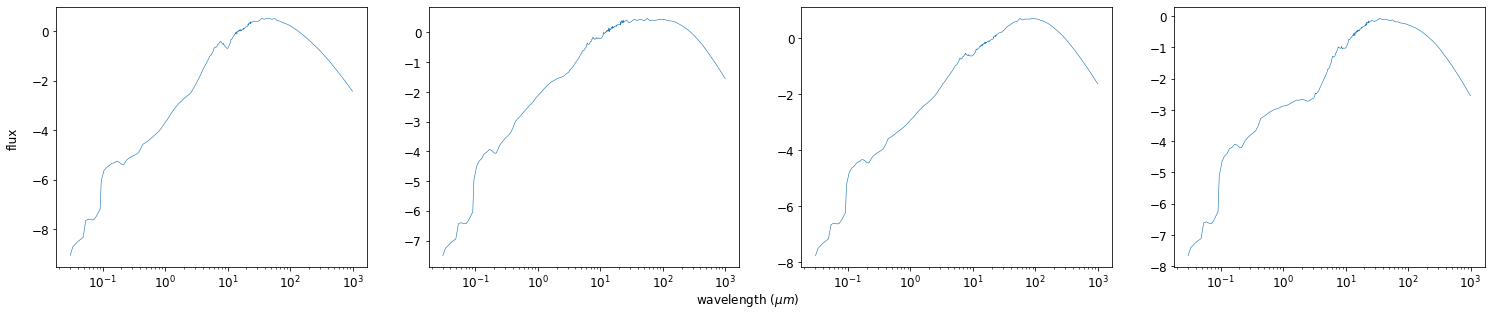

In [7]:
netG.eval()

wavelengths = np.load(osp.join(data_folder, "wavelenths_complete.npy")).astype(np.float32)

#plot a random sample (4) generated by netG
latent_rand = torch.randn(4, LATENT_SIZE, device=device)
for i in range(4):
    latent_rand[i] = project_l2_ball(latent_rand[i])

#change font size
plt.rcParams.update({'font.size':12})
fig = plt.figure(figsize=[4*6.4, 4.8])
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
axis = [ax1,ax2,ax3,ax4]

for i in range(4):
    sample = netG(latent_rand[i].unsqueeze(0)).squeeze(0).detach().numpy()
    axis[i].set_xscale('log')
    #axis[i].set_yscale('log')
    axis[i].plot(wavelengths[:NLA_max], sample, linewidth=0.6)
    
fig.text(0.5, 0.03, 'wavelength $(\u03bcm)$', ha='center', va='center')
fig.text(0.102, 0.5, 'flux', ha='center', va='center', rotation='vertical')